# Description
## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

# Load Packages

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist
 
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# Load Data

In [3]:
df = pd.read_csv('Credit_Card_Customer_Data.csv')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


Data looks good so far. 

# Basic Analysis

Let's start the Sl_No and Customer Key columns since we will not be needing them.

In [4]:
df.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

In [5]:
print(df.head())
print(df.shape)

   Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3  
(660, 5)


This dataset has 660 data points and 5 columns - 4 independent and 1 dependent.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


Observations:
- The mean credit limit of customers at AllLife Bank is \$34.5k, with a high standard deviation. Even though more than 75\% of the customers' credit limits are within \$48k, the maximum limit goes up to \$200k
- The average customer has around 4.7 credit cards and 75% of them have more than 3 cards. The maximum is 10, and perhaps the outliers are worth checking.
- A customer averages about 2.4 annual visits to the bank with at least 75% making at least one annual visit.
- Online visit are slightly higher than in person visits, averaging about 2.6 per year, but with a higher standard deviation of 2.9 visits, the maximum being 15. We can check some outliers in this column.
- Total calls made average about 3.5 per year, with 75% customers making at most 5 calls.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [82]:
# let's look at unique values for all discrete valued columns
num_cols = list(df.columns)
for col in num_cols:
    if col not in ['Avg_Credit_Limit']:
        print(f"Value counts for {col}:")
        print(df[col].value_counts())

Value counts for Total_Credit_Cards:
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64
Value counts for Total_visits_bank:
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
Value counts for Total_visits_online:
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64
Value counts for Total_calls_made:
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64


All columns are numerical, and have non-negative and non null values. Let's transition to Exploratory Data Analysis. At some point, we should check for values that are 0 for relevant columns, such as Avg_Credit_Limit.

# Exploratory Data Analysis (EDA)

## Univariate Analysis

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Count'>

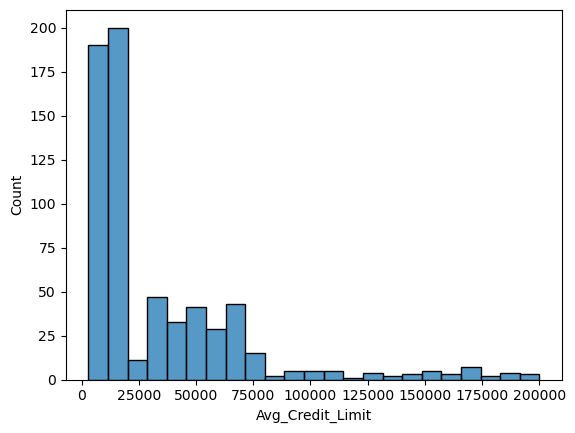

In [8]:
sns.histplot(data=df, x='Avg_Credit_Limit')

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Count'>

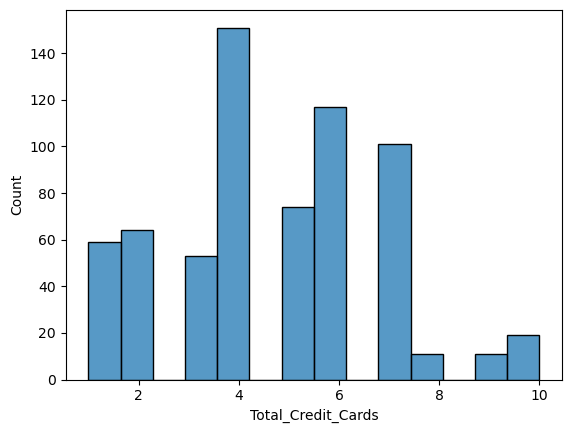

In [9]:
sns.histplot(data=df, x='Total_Credit_Cards')

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Count'>

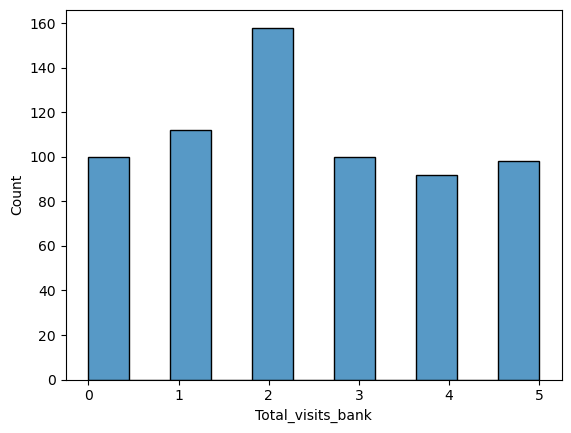

In [10]:
sns.histplot(data=df, x='Total_visits_bank')

<AxesSubplot:xlabel='Total_visits_online', ylabel='Count'>

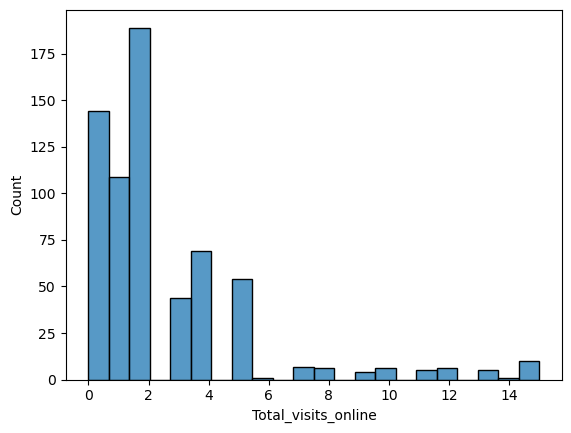

In [11]:
sns.histplot(data=df, x='Total_visits_online')

<AxesSubplot:xlabel='Total_calls_made', ylabel='Count'>

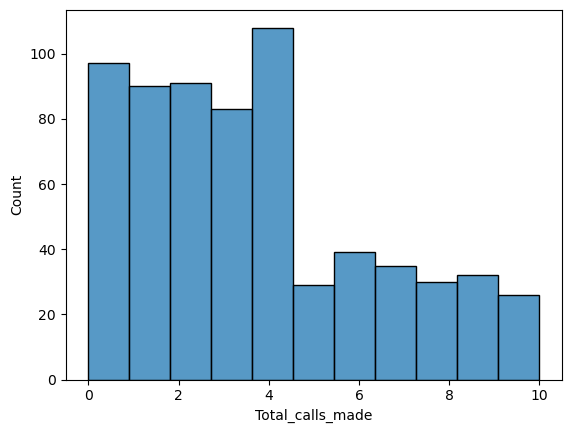

In [12]:
sns.histplot(data=df, x='Total_calls_made')

## Bivariate Analysis

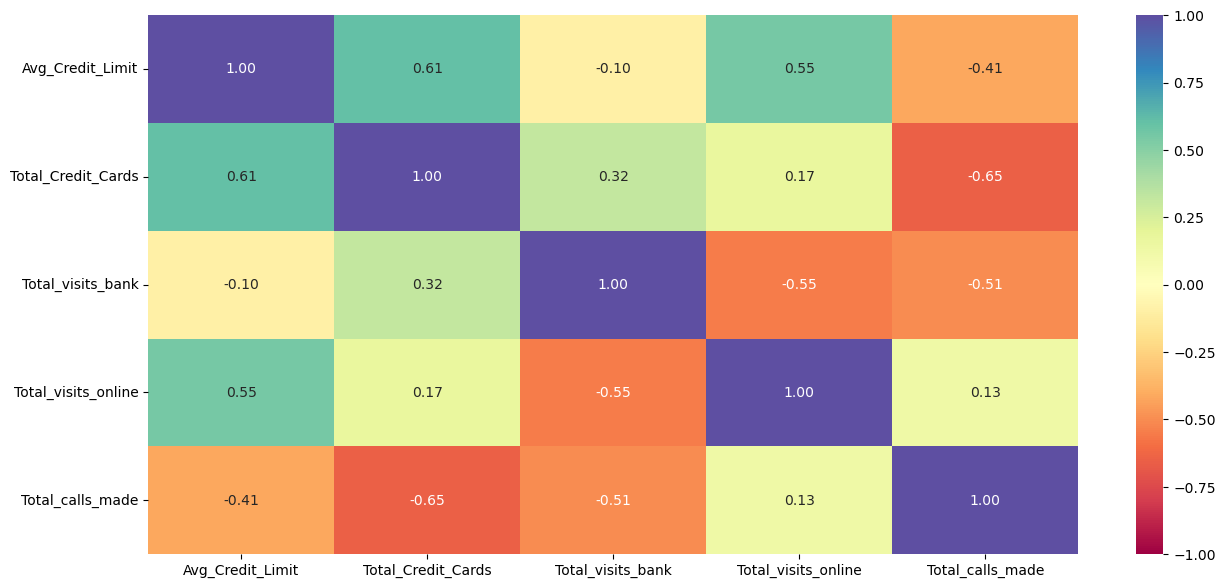

In [22]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    df[list(df.columns)].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Observations:

-

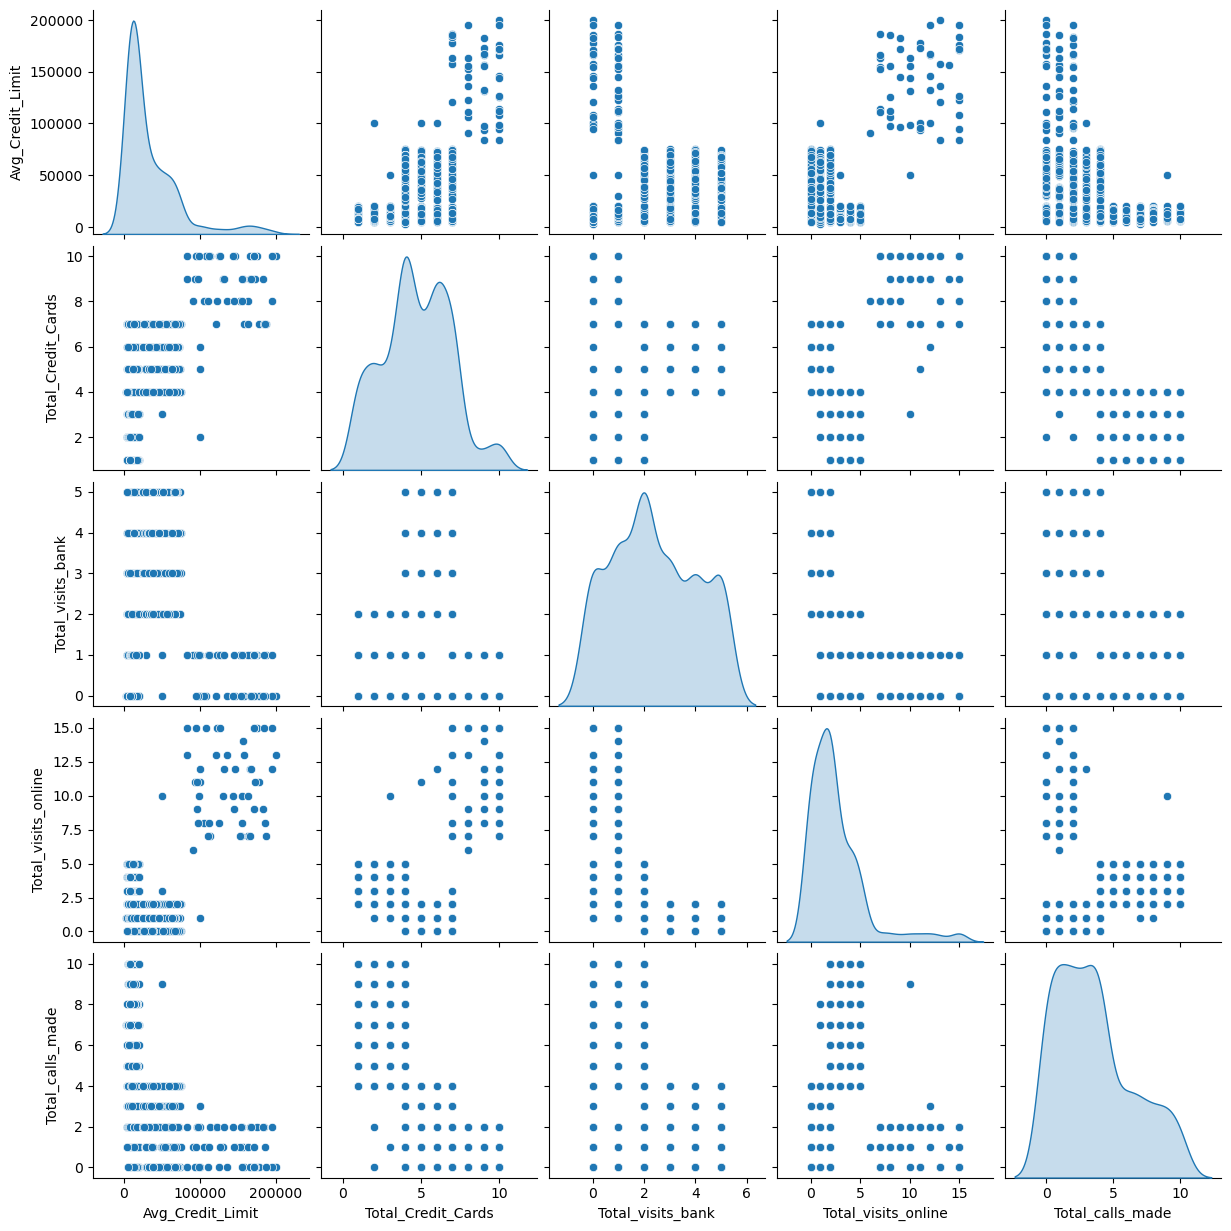

In [34]:
sns.pairplot(data=df, diag_kind='kde')

Observations

-

## Clustering

In [27]:
sc = StandardScaler()
scaled_data = sc.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
df_scaled

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537
656,1.314621,2.443892,-0.860451,3.543188,-0.553005
657,2.937092,1.520613,-0.860451,2.179629,-0.902271
658,3.655235,2.443892,-0.860451,4.224968,-1.251537


### K-Means Clustering

### Hierarchical Clustering

In [28]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553604.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [29]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


Let's explore different linkage methods with Euclidean distance only.

In [30]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [31]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


We see that the cophenetic correlation is still maximum with Euclidean distance and average linkage.

Let's see the dendrograms for the different linkage methods.

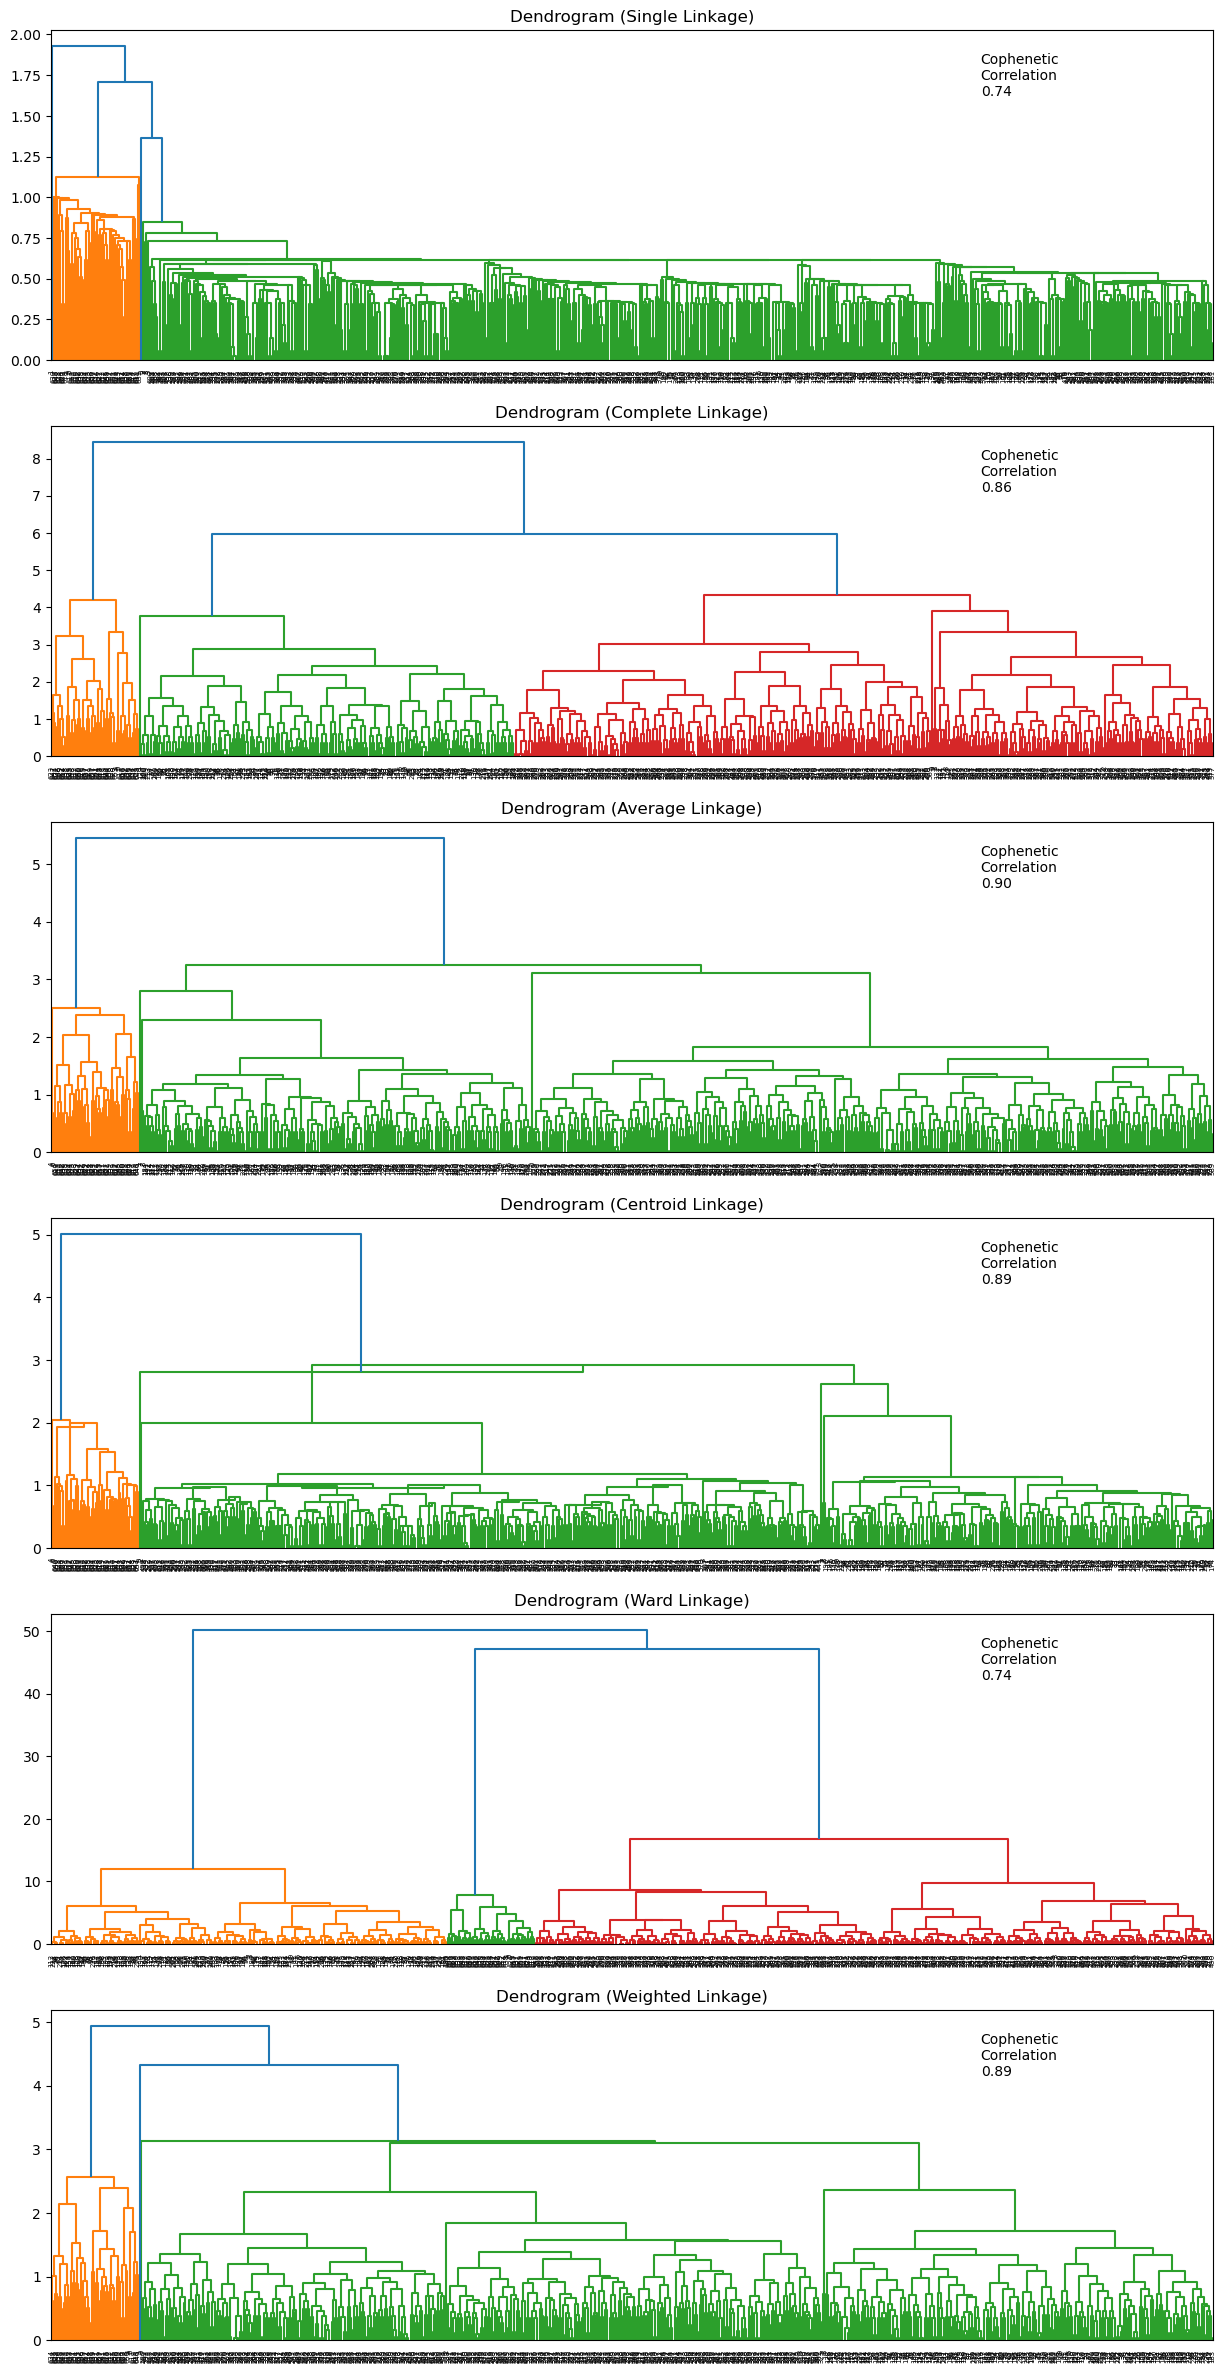

In [33]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

Observations:

 - The Cophentic correlation is highest for average linkage method, so we will move forward with this method.
 - About 7 clusters seem reasonable from the dendrogram of the average linkage.

In [87]:
HCmodel = AgglomerativeClustering(n_clusters=7, affinity="euclidean", linkage="average")
HCmodel.fit(df_scaled)

AgglomerativeClustering(linkage='average', n_clusters=7)

In [88]:
df_HC = df.copy()
df_scaled_HC = df_scaled.copy()

df_scaled_HC['HC_clusters'], df_HC['HC_clusters'] = HCmodel.labels_, HCmodel.labels_

#### Cluster Profiling - HC

In [89]:
cluster_profile_HC = df_HC.groupby('HC_clusters').mean()
cluster_profile_HC

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_clusters,,,,,
0,12027.027027,2.400901,0.932432,3.531532,6.873874
1,150125.000000,8.937500,0.500000,14.250000,0.875000
2,139062.500000,8.843750,0.687500,9.187500,1.093750
3,100000.000000,2.000000,1.000000,1.000000,0.000000
4,50000.000000,3.000000,0.000000,10.000000,9.000000
5,100000.000000,5.500000,0.000000,11.500000,2.500000
6,33541.450777,5.520725,3.492228,0.984456,2.010363


In [93]:
cluster_profile_HC["count_in_each_segment"] = (
    df_HC.groupby("HC_clusters")['Avg_Credit_Limit'].count().values
)

In [91]:
# lets display cluster profile
cluster_profile_HC.style.highlight_max(color="blue", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_clusters,,,,,,
0,12027.027027,2.400901,0.932432,3.531532,6.873874,222
1,150125.000000,8.937500,0.500000,14.250000,0.875000,16
2,139062.500000,8.843750,0.687500,9.187500,1.093750,32
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1
4,50000.000000,3.000000,0.000000,10.000000,9.000000,1
5,100000.000000,5.500000,0.000000,11.500000,2.500000,2
6,33541.450777,5.520725,3.492228,0.984456,2.010363,386


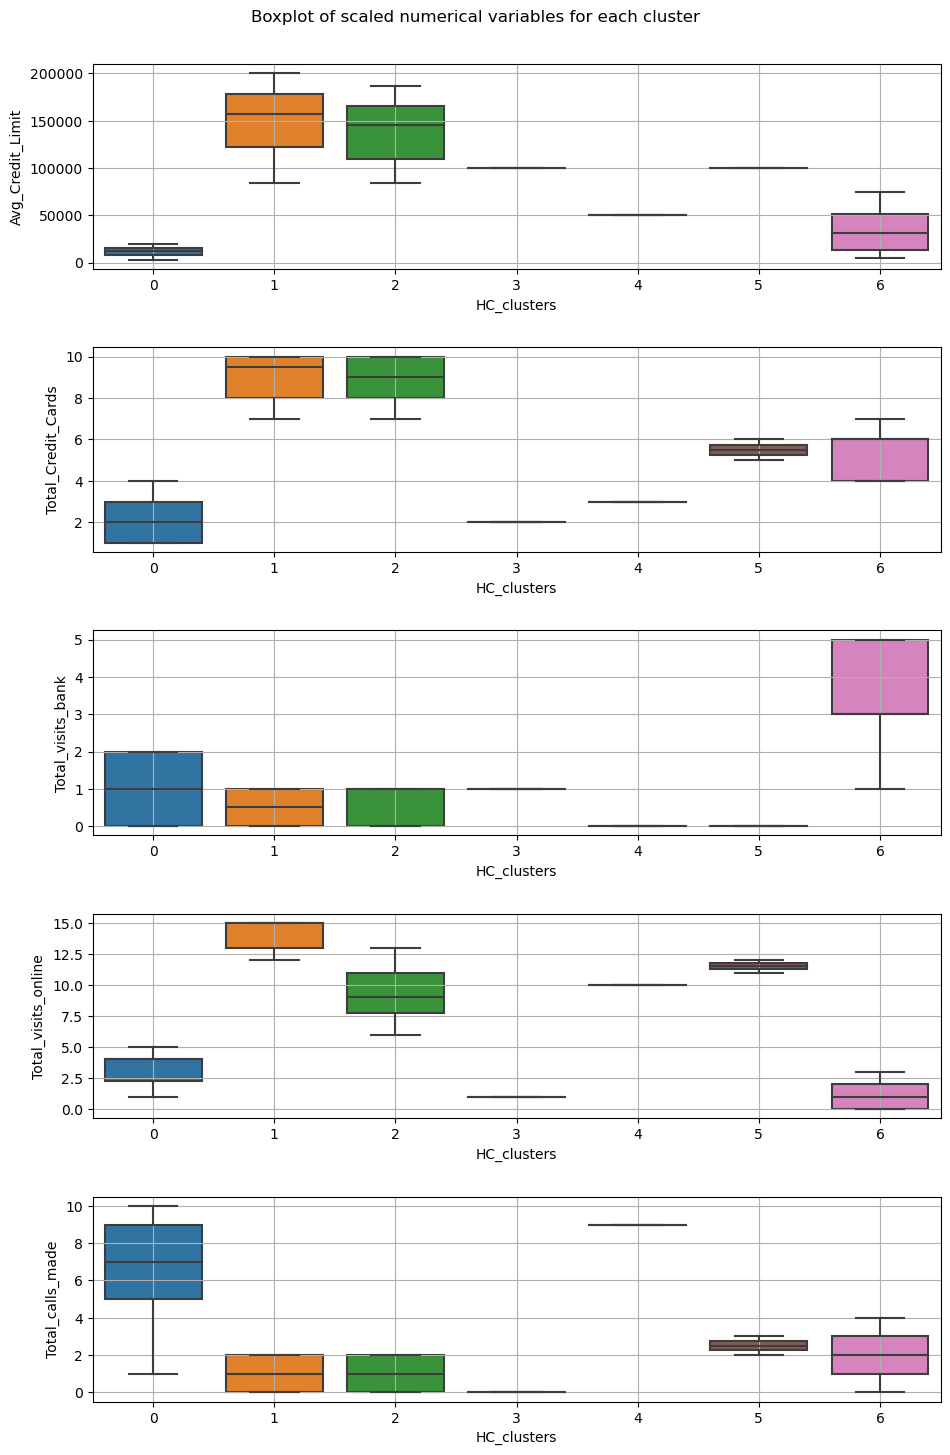

In [92]:
# plot each column/variable across each cluster to see the diversity
fig, axes = plt.subplots(5, figsize=(10, 15))
num_cols = list(df_HC.columns)
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i],
        y=df_HC[num_cols[i]],
        x=df_HC["HC_clusters"],
    );
    axes[i].grid();

fig.tight_layout(pad=2.5);


In [94]:
cluster_profile_HC.style.highlight_max(color="blue", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_clusters,,,,,,
0,12027.027027,2.400901,0.932432,3.531532,6.873874,222
1,150125.000000,8.937500,0.500000,14.250000,0.875000,16
2,139062.500000,8.843750,0.687500,9.187500,1.093750,32
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1
4,50000.000000,3.000000,0.000000,10.000000,9.000000,1
5,100000.000000,5.500000,0.000000,11.500000,2.500000,2
6,33541.450777,5.520725,3.492228,0.984456,2.010363,386


#### Insights for HC | Clusters = 7

We will discuss Clusters 0,1,2, and 6 since the others have only 1 or 2 customers.

<b> Cluster 0: </b>
- There are 222 customers in this cluster, second highest in proportion
- Customers here have the lowest average credit limit, with a low amount of total credit cards
- This cluster' customers have made the second most amount of calls to the bank, with a 'normal' amount of online and in person visits
- Perhaps the customers had issues/queries because of which they made so many calls, or perhaps they wanted to make payments over the phone.

<b> Cluster 1: </b>
- There are 16 customers in this cluster
- Customers found here have the highest credit limit AND amount of credit cards, as well as the highest number of online visits
- In person visits and calls made are low.
- The reasons behind so many online visits can be plenty for this group, perhaps for frequent online payments, checking their balance (which might tend to be high because of higher financial service usage), etc.

<b> Cluster 2: </b>
- There are 32 customers in this cluster
- Similar to cluster 1, these customers have a high credit limit and amount of credit cards, but a lower amount of online visits than cluster 1, similar to clusters 4 amd 5.

<b> Cluster 6: </b>
- This has the highest proportion of customers, the total number being 386.
- Customers belonging here have the highest number of in person visits to the bank.
- This cluster's customers' average credit limit is about the same as the entire data set's average, but a higher-than-group-average number of credit cards.
- Low amounts of online visits and total calls made.


##### Recommendations

- Clusters 1 and 2 are important customer profiles to target new customers for the bank, since they have the highest usage of the bank's financial services, AND they are low maintenance customers in terms of communication; they make a low number of calls and in person visits, albeit high online visits.

Note: No need to implement dimensionality reduction since there are only 5 columns and >600 data points.

### Comparison between Heirarchical and K-Means